In [1]:
from IPython.display import display
import os
import IPython
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
warnings.filterwarnings('ignore')
# Define the starting frequency for "A" note
# Human hearing range is typically 20 Hz to 20 kHz
# We start with 55 Hz which is an "A" (calculated by dividing 440 Hz by 2 three times)
curr_freq = 55
freq_list = []

# Calculate the frequencies for 8 octaves, each with 12 notes
for i in range(96): 
    freq_list.append(curr_freq)
    curr_freq *= np.power(2, 1/12)  # Multiply by 2^(1/12) to get the next note frequency

# Reshape the frequency list into an 8x12 array and create a DataFrame for better visualization
freq_array = np.reshape(np.round(freq_list, 1), (8, 12))
cols = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
df_note_freqs = pd.DataFrame(freq_array, columns=cols)

# Display the DataFrame
print("NOTE FREQUENCIES IN WESTERN MUSIC")
df_note_freqs.head(10)

NOTE FREQUENCIES IN WESTERN MUSIC


,A,A#,B,C,C#,D,D#,E,F,F#,G,G#
0,55.0,58.3,61.7,65.4,69.3,73.4,77.8,82.4,87.3,92.5,98.0,103.8
1,110.0,116.5,123.5,130.8,138.6,146.8,155.6,164.8,174.6,185.0,196.0,207.7
2,220.0,233.1,246.9,261.6,277.2,293.7,311.1,329.6,349.2,370.0,392.0,415.3
3,440.0,466.2,493.9,523.3,554.4,587.3,622.3,659.3,698.5,740.0,784.0,830.6
4,880.0,932.3,987.8,1046.5,1108.7,1174.7,1244.5,1318.5,1396.9,1480.0,1568.0,1661.2
5,1760.0,1864.7,1975.5,2093.0,2217.5,2349.3,2489.0,2637.0,2793.8,2960.0,3136.0,3322.4
6,3520.0,3729.3,3951.1,4186.0,4434.9,4698.6,4978.0,5274.0,5587.7,5919.9,6271.9,6644.9
7,7040.0,7458.6,7902.1,8372.0,8869.8,9397.3,9956.1,10548.1,11175.3,11839.8,12543.9,13289.8


In [4]:
path = 'Chords_Audio/Audio_Files'

In [5]:
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

In [7]:
data = []
max_harm_length = 0 
for dirname, _, filenames in os.walk(path):
    print(f"Checking directory: {dirname}")
    for filename in filenames:
        if filename.endswith('.wav'):  # Ensure the file is a wav audio file
            foldername = os.path.basename(dirname)
            full_path = os.path.join(dirname, filename)
            # print(f"Processing file: {full_path}")
            freq_peaks = find_harmonics(full_path)
            
            max_harm_length = max(max_harm_length, len(freq_peaks))
            
            cur_data = [foldername, filename]
            if len(freq_peaks) > 0:
                cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
            else:
                cur_data.extend([np.nan, np.nan, 0])
            cur_data.extend(freq_peaks)
            
            data.append(cur_data)

Checking directory: Chords_Audio/Audio_Files
Checking directory: Chords_Audio/Audio_Files\Major
Checking directory: Chords_Audio/Audio_Files\Minor


In [8]:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


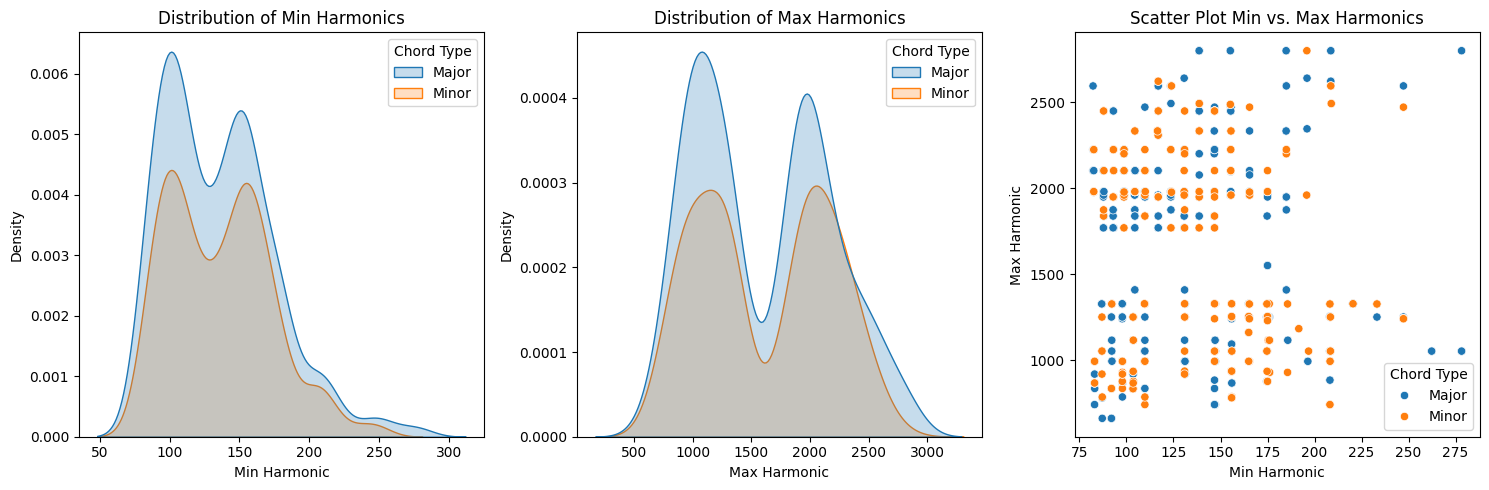

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(ax=axes[0], data=df, x="Min Harmonic", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Max Harmonic", hue="Chord Type", shade=True)
sns.scatterplot(ax=axes[2], data=df, x="Min Harmonic", y="Max Harmonic",hue="Chord Type")
axes[0].set_title("Distribution of Min Harmonics")
axes[1].set_title("Distribution of Max Harmonics")
axes[2].set_title("Scatter Plot Min vs. Max Harmonics")
fig.tight_layout()
plt.show()

In [10]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [11]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

In [12]:
df_original = df.copy()

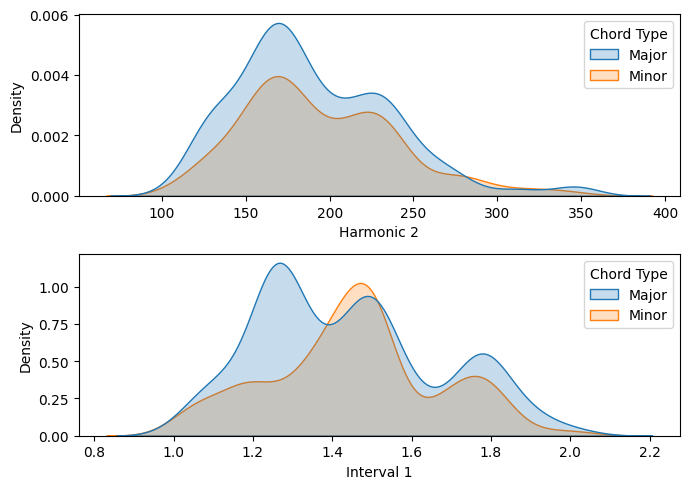

In [13]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [14]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)
    
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_0.wav,130.67,1838.22,21,130.67,165.33,196.00,262.22,330.22,...,1.049688,1.197417,1.061102,1.103298,1.017656,1.113492,1.005082,1.043128,1.145029,1.166709
1,Major,Major_1.wav,131.11,993.33,16,131.11,165.33,174.67,196.44,261.78,...,1.125534,1.111533,1.008802,1.389790,1.080752,NaN,NaN,NaN,NaN,NaN
2,Major,Major_10.wav,130.91,1408.64,20,130.91,185.00,234.09,262.27,329.55,...,1.054971,1.063154,1.176470,1.011280,1.055261,1.124936,1.053495,1.124803,1.067888,NaN
3,Major,Major_100.wav,155.45,2449.09,27,155.45,195.91,278.18,311.36,349.55,...,1.113791,1.007590,1.064304,1.119760,1.122995,1.039390,1.019581,1.059233,1.059000,1.102333
4,Major,Major_101.wav,155.91,1093.64,20,155.91,175.45,196.82,273.18,278.18,...,1.188654,1.191808,1.060464,1.057780,1.251999,1.069225,1.120785,1.124279,1.038861,NaN


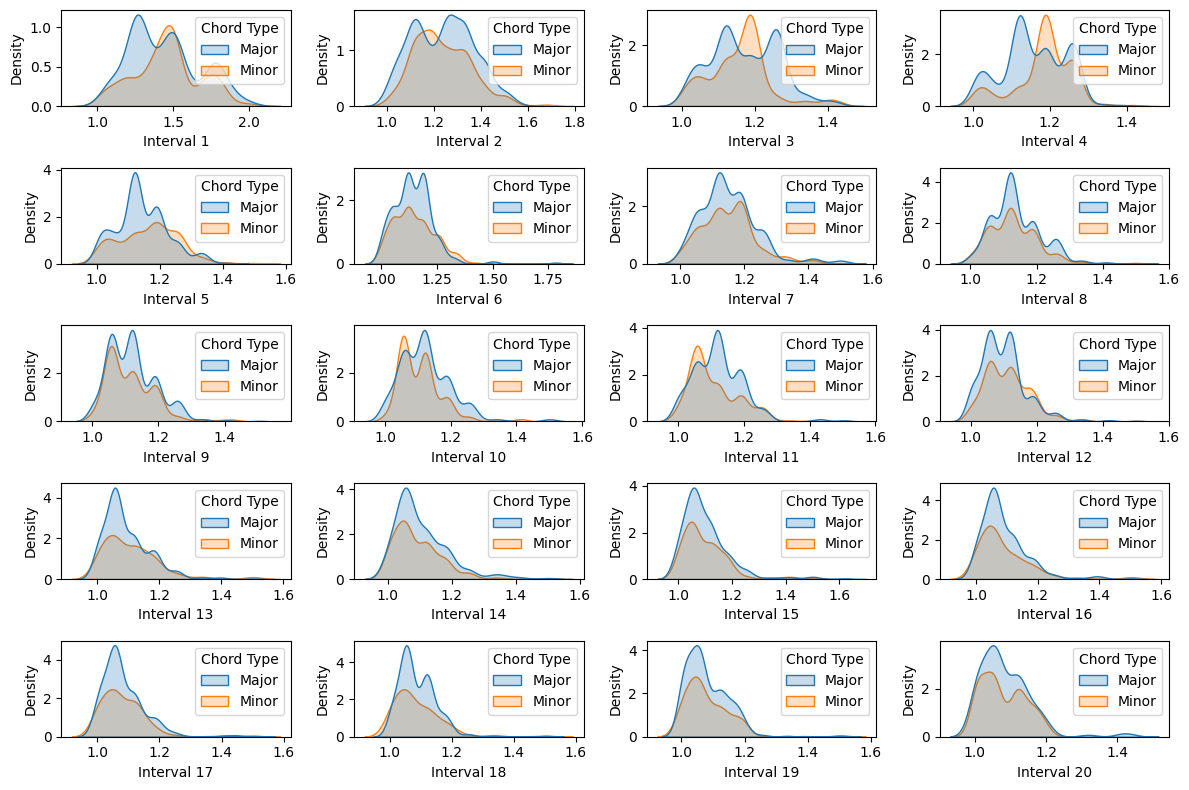

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

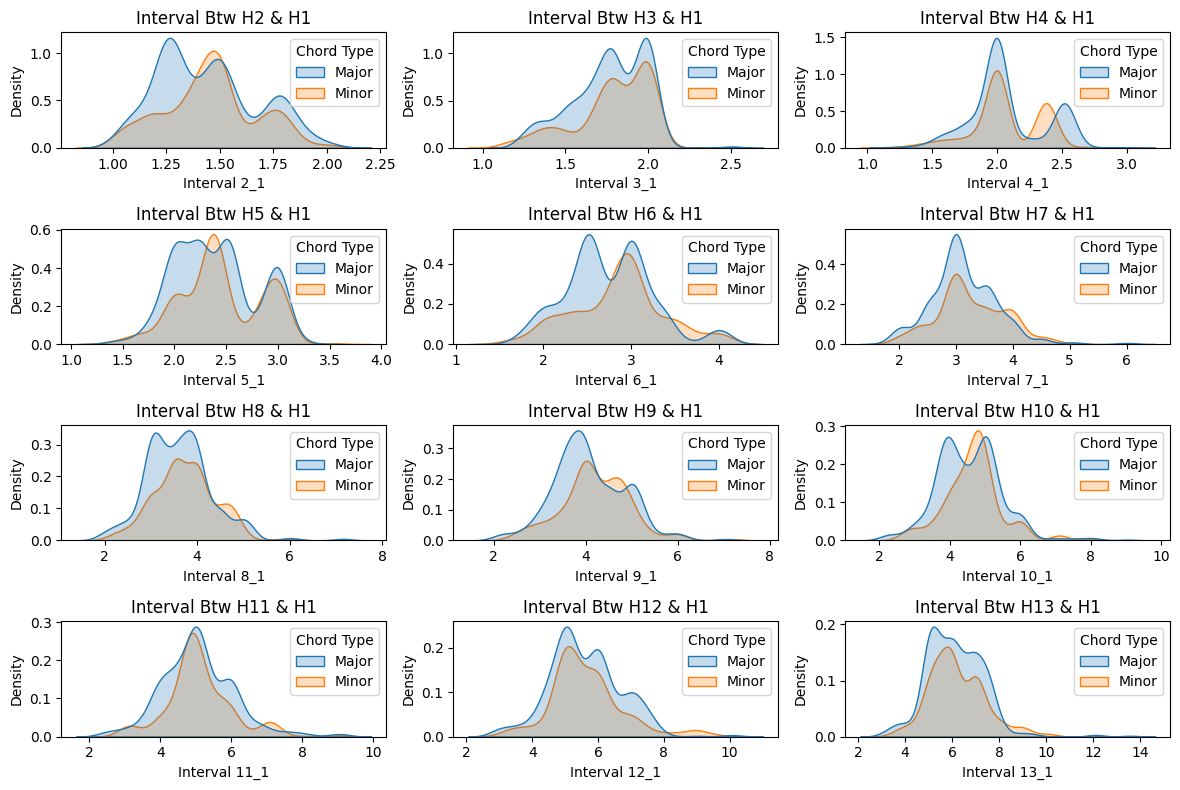

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)


In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4",
           "Interval 4_1", "Interval 5_1", "Interval 6_1"]

# Splitting the data into train and validation sets
X = df[columns]
y = df["Chord Type"]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Standardizing the data
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)

# Reshaping data to fit into CNN model (CNN expects 3D input)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

In [21]:
model = Sequential()
model.add(Conv1D(256, kernel_size=4, activation='relu', input_shape=(train_X.shape[1], 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(train_X, train_y, epochs=200, validation_data=(val_X, val_y), batch_size=64)

Epoch 1/200
11/11 [==============================] - 1s 24ms/step - loss: 0.6527 - accuracy: 0.6303 - val_loss: 0.6135 - val_accuracy: 0.6628
Epoch 2/200
11/11 [==============================] - 0s 7ms/step - loss: 0.5949 - accuracy: 0.7540 - val_loss: 0.5773 - val_accuracy: 0.7500
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.5430 - accuracy: 0.7991 - val_loss: 0.5453 - val_accuracy: 0.7965
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 0.4937 - accuracy: 0.8326 - val_loss: 0.5246 - val_accuracy: 0.8023
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 0.4578 - accuracy: 0.8239 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 0.4365 - accuracy: 0.8384 - val_loss: 0.5023 - val_accuracy: 0.7500
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 0.4161 - accuracy: 0.8253 - val_loss: 0.5087 - val_accuracy: 0.7849
Epoch 8/200


In [23]:
val_loss, val_accuracy = model.evaluate(val_X, val_y)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Predicting the validation set
val_y_pred = (model.predict(val_X) > 0.5).astype("int32")

6/6 [==============================] - 0s 2ms/step - loss: 0.4240 - accuracy: 0.9360
Validation Loss: 0.42404404282569885
Validation Accuracy: 0.9360465407371521
6/6 [==============================] - 0s 2ms/step


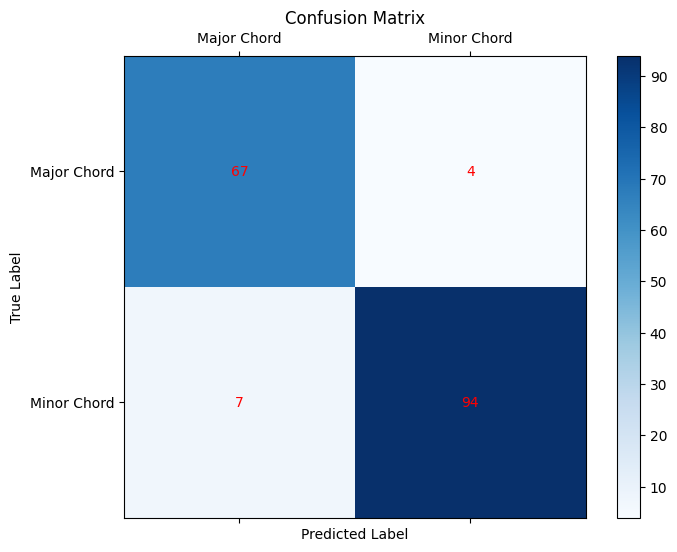

In [25]:
conf_matrix = confusion_matrix(val_y, val_y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar(cax)
ax.set_xticklabels([''] + ['Major Chord', 'Minor Chord'])
ax.set_yticklabels([''] + ['Major Chord', 'Minor Chord'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, val, ha='center', va='center', color='red')

plt.title('Confusion Matrix')
plt.show()

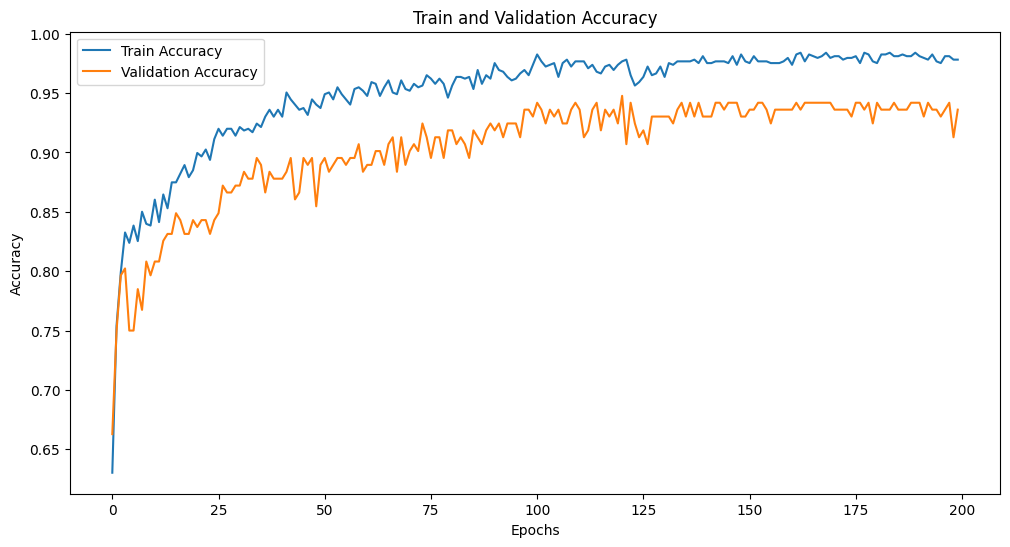

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()